# Face Clustering using a facenet_pytorch wrapper and HDBSCAN

This notebook implements an end-to-end unsupervised pipeline:
1. Face detection and alignment (MTCNN)
2. Embedding extraction (Facenet-VGGFace2 model)
3. Density-based clustering (HDBSCAN)
4. Dimensionality reduction (PCA) 
5. Diagnostic visualization (condensed tree)


In [19]:
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import torch

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from hdbscan import HDBSCAN

from pathlib import Path
import glob, os, csv
from shutil import copy2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = 'cpu'
project_root = Path.cwd().parent


#### Explanation for Unfamiliar Imports
The unfamiliar libraries here are probably glob, facenet_pytorch, and maybe warnings. 

Glob simply is a built in python library that finds pathnames using pattern matching rules similar to the Unix shell. It's simpler to use than surfing each image file with os or open(). The facenet_pytorch module is a deep learning model for face recognition that was introduced by Google researchers in a paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering” by Schroff et al. The “facenet_pytorch” library is a PyTorch implementation of the FaceNet model, which allows you to utilize FaceNet for face recognition tasks in your own projects. And the warning libraries is because I was getting some warnings of divide by zero errors but this did not effect performance so I just told the interpreter to ignore them. 

In [15]:
#Initializing Facenet
mtcnn = MTCNN(
    image_size=182,
    margin=40,
    keep_all=False,
    post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


#### Setting Up FaceNet 

##### The MTCNN (Multi-task Cascaded Convolutional Networks) is used for face detection.
- MTCNN is a deep learning architecture for face detection, known for its efficiency in detecting faces at varying scales and angles.
- It's three-stage face detection system (P-Net, R-Net, O-Net) progressively refines results.

##### The InceptionResnetV1 model is loaded for extracting face embeddings.
- Inception-ResNet combines Inception architecture and residual connections for efficient feature extraction in computer vision tasks.

In [16]:
#Load the Images
faces_dir = (project_root / "faces")  # go up one folder
images = list(faces_dir.glob("*.jpg"))

len(images) # 405 provided in faces. It is understood that this is variable

405

In [7]:
#Extract embeddings
embeddings = []
valid_paths = []

for img_path in images:
    img = Image.open(img_path).convert("RGB")
    face = mtcnn(img)

    if face is None:
        continue

    face = face.unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = resnet(face).cpu().numpy()[0]

    embeddings.append(embedding)
    valid_paths.append(img_path)

len(embeddings)


403

In [9]:
#Normalize + Clean
X = np.array(embeddings, dtype=np.float32)
X = normalize(X, norm='l2')



#### Why Normalize FaceNet Embeddings?

Normalizing image embeddings from facenet_pytorch scales all embedding vectors to unit length (magnitude of 1), which is essential for accurate face comparison.

**Three Key Benefits:**

**Consistent Similarity Metrics** – Normalization ensures distance calculations (Euclidean distance, cosine similarity) measure the actual angular difference between faces, not vector magnitude.

**Algorithm Compatibility** – It aligns with the triplet loss function's core assumption from FaceNet's training: that embeddings exist on a unit hypersphere.

**Improved Performance** – It stabilizes downstream ML algorithms that rely on distance-based comparisons or gradient descent.

**In Plain Terms:**
FaceNet outputs 512-dimensional vectors—high-dimensional points in space that can vary wildly in magnitude. Without normalization, comparing these vectors is like trying to measure the similarity between two directions when one person is pointing 10 feet away and another is pointing 1000 feet away. By normalizing to unit length, we're essentially saying "ignore how far you're pointing, just tell me what direction." This makes Euclidean distance a reliable metric for measuring how similar two faces actually are, rather than being thrown off by arbitrary vector lengths.

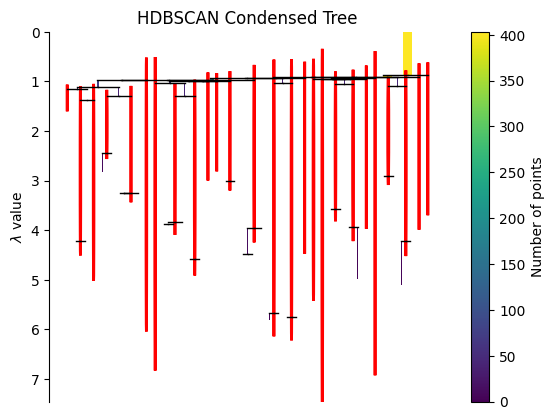

In [10]:
#HDBSCAN Clustering
clusterer = HDBSCAN(
        min_cluster_size=3,
        min_samples=1,
        metric='euclidean',
        cluster_selection_epsilon=0.2)
labels = clusterer.fit_predict(X)
np.unique(labels)

# ---- HDBSCAN condensed tree diagnostic ----
clusterer.condensed_tree_.plot(select_clusters=True)
plt.title("HDBSCAN Condensed Tree")
plt.show()

##### Evaluating Clustering Performance

This condensed tree visualization shows how HDBSCAN identified clusters in the data. Each horizontal bar represents a cluster at different density thresholds (lambda values).

**How to Read This Plot:**
- **Bar length** indicates cluster persistence across density levels longer bars mean more stable, well defined clusters
- **Lambda (λ) values** on the y axis represent density thresholds, increasing from bottom to top as the algorithm examines denser regions
- **Horizontal position** shows the hierarchical relationships as clusters split or merge

**What This Tells Us:**
Longer, more persistent bars indicate high quality clusters where data points are tightly grouped. 
Short bars suggest weaker or noisier clusters that only exist at specific density levels. 
This visualization helps assess whether HDBSCAN successfully identified meaningful groupings in the face embeddings.

In [17]:
#Small helper for what we're about to do
jupartifacts_dir = project_root / "jupArtifacts" 
#made new jupyter directory to not mess with my already existing artifacts dir
jupartifacts_dir.mkdir(exist_ok=True)

In [21]:
# clusters.csv
with open(jupartifacts_dir / "clusters.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_filename", "cluster_id"])

    for label, path in zip(labels, valid_paths):
        writer.writerow([Path(path).name, label])


# outliers.csv
with open(jupartifacts_dir / "outliers.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_filename", "cluster_id"])

    for label, path in zip(labels, valid_paths):
        if label == -1:
            writer.writerow([Path(path).name, label])


# Copy images into cluster folders
for label, path in zip(labels, valid_paths):
    cluster_folder = jupartifacts_dir / f"cluster_{label}"
    cluster_folder.mkdir(exist_ok=True)
    copy2(path, cluster_folder / Path(path).name)

##### The above code is here to show that the code works outside of the test.py file

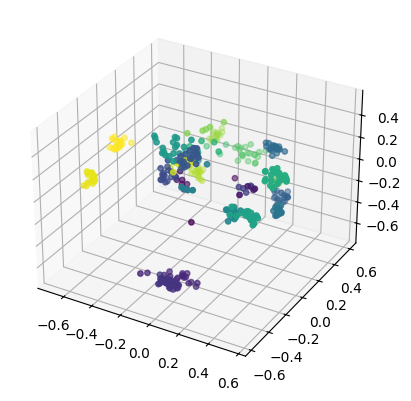

In [22]:
#Quick 3D Vizualization of the clusters like in the artifacts directory
pca = PCA(n_components=3)
points3d = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points3d[:,0], points3d[:,1], points3d[:,2], c=labels, s=15)
plt.show()


### Reflection

This project marked my first experience with Jupyter Notebooks, and I was pleasantly surprised by how intuitive it became once I got past the initial learning curve. The combination of code and markdown documentation felt natural—like writing in LaTeX but with more flexibility.

**Parameter Selection and Rationale**

I chose Euclidean distance because once the face vectors are normalized to the same length, this distance measures how similar two faces actually are—like comparing directions rather than raw coordinates. For the clustering parameters: `min_cluster_size=3` means at least 3 faces are needed to form a group (prevents random noise from creating fake clusters), `min_samples=1` lets faces join a cluster even if they only match one other face closely (helpful since the same person can look different in various photos), and `cluster_selection_epsilon=0.2` is the maximum distance two faces can be apart and still be considered the same person. I chose 0.2 through testing—faces of the same person usually stay within this distance, while different people are farther apart.

**Technical Challenges & Learning**

The most rewarding challenge was implementing dimensionality reduction techniques I'd previously only encountered in research papers. Working hands-on with manifold learning deepened my understanding of the theoretical concepts that initially drew me to pursue graduate studies in neural network generalization.

**Iterative Development**

I started with the `face_recognition` library (a wrapper around dlib), which provided decent face detection but fell short in clustering performance with DBSCAN. Pivoting to `facenet_pytorch` proved crucial—the jump from 128-dimensional to 512-dimensional embeddings required switching to HDBSCAN, but the improved accuracy made the architectural changes worthwhile.

**Future Work**

While time constraints prevented me from building the CLI dashboard mentioned in the stretch goals, I'd be excited to revisit this feature. The problem itself was engaging enough that I genuinely enjoyed working through it.

On top of this, I am uncertain how to evaluate the cluster correctly. This is something I want to ask in another interview if given the opportunity. I did some research and it seems trivial, but I think what I have already is a good metric for evaluation (i.e. HDBSCAN Condense Tree).

**Reproducibility**

I've included a `README_.md` in the parent directory with step-by-step instructions for reproducing these results.

---

Thank you for designing such a thoughtful problem—it gave me valuable hands-on experience and, frankly, has me even more enthusiastic about the potential to work on these kinds of challenges as an intern at GenLift.